In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

In [3]:
os.chdir('/content/drive/My Drive/GitHub Repositories/Tuberculosis/Segmentation')
images = np.load('./data/images.npy')
# Z-score Normalization
mean = np.mean(images)
std = np.std(images)
images -= mean
images /= std


masks = np.load('./data/masks.npy')
# Normalize masks to [0, 1]
masks /= 255. 

print('Images: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(images.shape, images.dtype, np.amax(images), np.amin(images)))
print('Masks: {} | Dtype: {} | Max-Val: {} | Min-Val: {}'.format(masks.shape, masks.dtype, np.amax(masks), np.amin(masks)))

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.077, random_state=2020)
print('Train Images: {} | Train Masks: {}'.format(images_train.shape, masks_train.shape))
print('Validation Images: {} | Validation Masks: {}'.format(images_test.shape, masks_test.shape))

Images: (336, 512, 512, 1) | Dtype: float32 | Max-Val: 1.4261432886123657 | Min-Val: -1.8582361936569214
Masks: (336, 512, 512, 1) | Dtype: float32 | Max-Val: 1.0 | Min-Val: 0.0
Train Images: (310, 512, 512, 1) | Train Masks: (310, 512, 512, 1)
Validation Images: (26, 512, 512, 1) | Validation Masks: (26, 512, 512, 1)


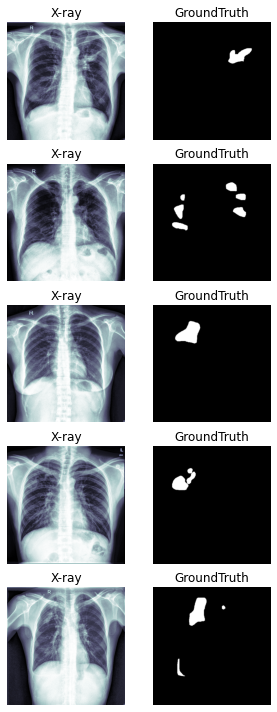

In [31]:
import matplotlib.pyplot as plt
import random
def plotMask(images, masks):
  rows = 5
  cols = 2
  fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(4, 10)) 
  for r in range(rows):
    ax[r][0].imshow(images[r, :, :, 0], cmap='bone')
    ax[r][0].set_title('X-ray', fontsize=12)
    ax[r][0].axis('off')

    ax[r][1].imshow(masks[r, :, :, 0], cmap='gray')
    ax[r][1].set_title('GroundTruth', fontsize=12)
    ax[r][1].axis('off')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2, hspace=0.2)
  plt.show()
  plt.close() 
  
plotMask(images_test, masks_test)


In [32]:
img_rows = 512
img_cols = 512
smooth = 1

def mean_iou(y_true, y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    iou = (true_positives)/(possible_negatives - true_negatives + possible_positives + K.epsilon())
    return K.mean(iou)  
  
def sensitivity(y_true,y_pred):
    true_positives=tf.reduce_sum(tf.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives=tf.reduce_sum(tf.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives+K.epsilon())

def specificity(y_true,y_pred):
    true_negatives=tf.reduce_sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives=tf.reduce_sum(K.round(K.clip((1-y_true), 0, 1)))
    return true_negatives / (possible_negatives+K.epsilon())

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
        how many relevant items are selected. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
        how many selected items are relevant. """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1score =  2 * ((precision * recall) / (precision + recall))
    return f1score

def FCN8_Architecture():
  inputs = tf.keras.layers.Input((img_rows, img_cols, 1))

  # Block 1
  block1 = tf.keras.layers.Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv1')(inputs)
  block1 = tf.keras.layers.BatchNormalization()(block1)
  block1 = tf.keras.layers.Activation('relu')(block1)
  block1 = tf.keras.layers.Conv2D(32, (3, 3), activation=None, padding='same', name='block1_conv2')(block1)
  block1 = tf.keras.layers.BatchNormalization()(block1)
  block1 = tf.keras.layers.Activation('relu')(block1)
  block1 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(block1)

  # Block 2
  block2 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv1')(block1)
  block2 = tf.keras.layers.BatchNormalization()(block2)
  block2 = tf.keras.layers.Activation('relu')(block2)
  block2 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same', name='block2_conv2')(block2)
  block2 = tf.keras.layers.BatchNormalization()(block2)
  block2 = tf.keras.layers.Activation('relu')(block2)
  block2 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(block2)

  # Block 3
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv1')(block2)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv2')(block3)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same', name='block3_conv3')(block3)
  block3 = tf.keras.layers.BatchNormalization()(block3)
  block3 = tf.keras.layers.Activation('relu')(block3)
  block3 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(block3)

  # Block 4
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv1')(block3)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv2')(block4)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same', name='block4_conv3')(block4)
  block4 = tf.keras.layers.BatchNormalization()(block4)
  block4 = tf.keras.layers.Activation('relu')(block4)
  block4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(block4)

  # o = block4
  block5 = tf.keras.layers.Conv2D(256, (5, 5), activation=None, padding='same')(block4)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)
  block5 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same')(block5)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)
  block5 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same')(block5)

  ### pool3 (12, 16, 128) --> (12, 16, 256)
  temp_block3 = tf.keras.layers.Conv2D(256, (3, 3), activation=None, padding='same')(block3)
  temp_block3 = tf.keras.layers.BatchNormalization()(temp_block3)
  temp_block3 = tf.keras.layers.Activation('relu')(temp_block3)
  
  ### concat1 [(16, 16, 256), (16, 16, 256)]
  block5 = tf.keras.layers.concatenate([block5, temp_block3], axis=3)
  block5 = tf.keras.layers.Conv2D(256, (3, 3), padding='same')(block5)
  block5 = tf.keras.layers.BatchNormalization()(block5)
  block5 = tf.keras.layers.Activation('relu')(block5)

  ### up2 (12, 16, 256) --> (24, 32, 128)
  block6 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same')(block5)
  block6 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(block6)
  block6 = tf.keras.layers.BatchNormalization()(block6)
  block6 = tf.keras.layers.Activation('relu')(block6)

  ### pool2 (24, 32, 64) --> (24, 32, 128)
  temp_block2 = tf.keras.layers.Conv2D(128, (3, 3), activation=None, padding='same')(block2)
  temp_block2 = tf.keras.layers.BatchNormalization()(temp_block2)
  temp_block2 = tf.keras.layers.Activation('relu')(temp_block2)

  ### concat2 [(24, 32, 128), (24, 32, 128)]--> (48, 64, 256)
  block6 = tf.keras.layers.concatenate([block6, temp_block2], axis=3)
  
  ### up3 (24, 32, 128) --> (48, 64, 64)
  block7 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(block6)
  block7 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(block7)
  block7 = tf.keras.layers.BatchNormalization()(block7)
  block7 = tf.keras.layers.Activation('relu')(block7)

  ### pool1 (48, 64, 32) --> (48, 64, 64)
  temp_block1 = tf.keras.layers.Conv2D(64, (3, 3), activation=None, padding='same')(block1)
  temp_block1 = tf.keras.layers.BatchNormalization()(temp_block1)
  temp_block1 = tf.keras.layers.Activation('relu')(temp_block1)

  ### concat3 [(48, 64, 64), (48, 64, 64)] --> (48, 64, 128)
  block7 = tf.keras.layers.concatenate([block7, temp_block1], axis=3)
  block7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(block7)
  block7 = tf.keras.layers.BatchNormalization()(block7)
  block7 = tf.keras.layers.Activation('relu')(block7)

  ### up (48, 64, 32) --> (96, 128, 32)
  block8 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(block7)
  ### mask out (96, 128, 32) --> (96, 128, 1)
  block8 = tf.keras.layers.Conv2D(1, (3, 3), padding='same')(block8)
  outputs = tf.keras.layers.Activation('hard_sigmoid')(block8)
  
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  return model

model = FCN8_Architecture()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=dice_coef_loss, metrics=[tf.keras.metrics.Accuracy(), dice_coef, sensitivity,
                                                                                  specificity, f1score, precision, recall, mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Epoch 1/100
155/155 [==============================] - ETA: 0s - loss: -0.4256 - accuracy: 0.9570 - dice_coef: 0.4256 - sensitivity: 0.4731 - specificity: 0.9805 - f1score: 0.4256 - precision: 0.4259 - recall: 0.4731 - mean_iou: 0.2779
Epoch 00001: val_loss improved from inf to -0.25936, saving model to ./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-best-model.h5
Prediction Results at epoch: 1 are below


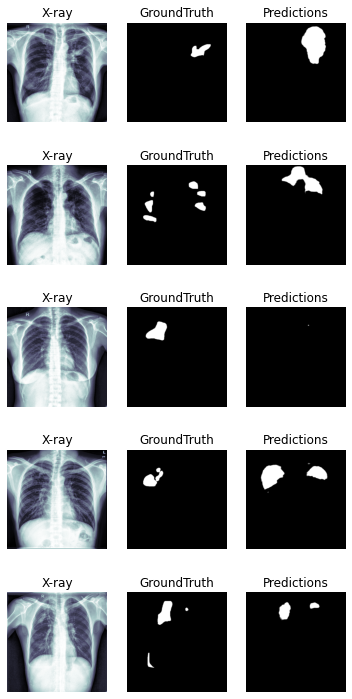

155/155 [==============================] - 78s 503ms/step - loss: -0.4256 - accuracy: 0.9570 - dice_coef: 0.4256 - sensitivity: 0.4731 - specificity: 0.9805 - f1score: 0.4256 - precision: 0.4259 - recall: 0.4731 - mean_iou: 0.2779 - val_loss: -0.2594 - val_accuracy: 0.9443 - val_dice_coef: 0.2594 - val_sensitivity: 0.4066 - val_specificity: 0.9618 - val_f1score: 0.2589 - val_precision: 0.1899 - val_recall: 0.4066 - val_mean_iou: 0.1487
Epoch 2/100
155/155 [==============================] - ETA: 0s - loss: -0.4423 - accuracy: 0.9586 - dice_coef: 0.4423 - sensitivity: 0.4947 - specificity: 0.9812 - f1score: 0.4423 - precision: 0.4415 - recall: 0.4947 - mean_iou: 0.2898
Epoch 00002: val_loss improved from -0.25936 to -0.28528, saving model to ./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-best-model.h5
155/155 [==============================] - 77s 498ms/step - loss: -0.4423 - accuracy: 0.9586 - dice_coef: 0.4423 - sensitivity: 0.4947 - specificity: 0.9812 - 

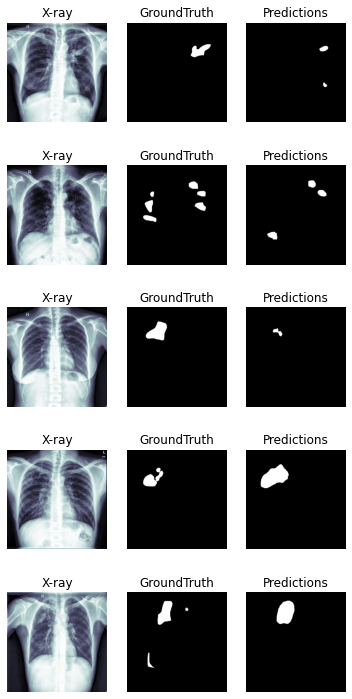

155/155 [==============================] - 78s 504ms/step - loss: -0.5884 - accuracy: 0.9708 - dice_coef: 0.5884 - sensitivity: 0.6057 - specificity: 0.9889 - f1score: 0.5885 - precision: 0.6025 - recall: 0.6057 - mean_iou: 0.4235 - val_loss: -0.4325 - val_accuracy: 0.9722 - val_dice_coef: 0.4325 - val_sensitivity: 0.4287 - val_specificity: 0.9877 - val_f1score: 0.4315 - val_precision: 0.4343 - val_recall: 0.4287 - val_mean_iou: 0.2751
Epoch 12/100
155/155 [==============================] - ETA: 0s - loss: -0.6041 - accuracy: 0.9716 - dice_coef: 0.6041 - sensitivity: 0.6264 - specificity: 0.9891 - f1score: 0.6041 - precision: 0.6167 - recall: 0.6264 - mean_iou: 0.4379
Epoch 00012: val_loss improved from -0.43246 to -0.45207, saving model to ./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-best-model.h5
155/155 [==============================] - 76s 493ms/step - loss: -0.6041 - accuracy: 0.9716 - dice_coef: 0.6041 - sensitivity: 0.6264 - specificity: 0.9891 -

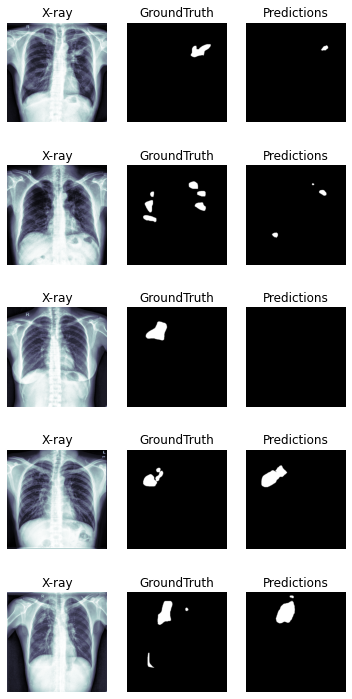

155/155 [==============================] - 75s 487ms/step - loss: -0.6528 - accuracy: 0.9746 - dice_coef: 0.6528 - sensitivity: 0.6669 - specificity: 0.9907 - f1score: 0.6530 - precision: 0.6603 - recall: 0.6669 - mean_iou: 0.4895 - val_loss: -0.4092 - val_accuracy: 0.9770 - val_dice_coef: 0.4092 - val_sensitivity: 0.3200 - val_specificity: 0.9946 - val_f1score: 0.4087 - val_precision: 0.5652 - val_recall: 0.3200 - val_mean_iou: 0.2568
Epoch 22/100
155/155 [==============================] - ETA: 0s - loss: -0.6605 - accuracy: 0.9750 - dice_coef: 0.6605 - sensitivity: 0.6757 - specificity: 0.9908 - f1score: 0.6608 - precision: 0.6674 - recall: 0.6757 - mean_iou: 0.4985
Epoch 00022: val_loss did not improve from -0.45207
155/155 [==============================] - 74s 477ms/step - loss: -0.6605 - accuracy: 0.9750 - dice_coef: 0.6605 - sensitivity: 0.6757 - specificity: 0.9908 - f1score: 0.6608 - precision: 0.6674 - recall: 0.6757 - mean_iou: 0.4985 - val_loss: -0.3047 - val_accuracy: 0.90

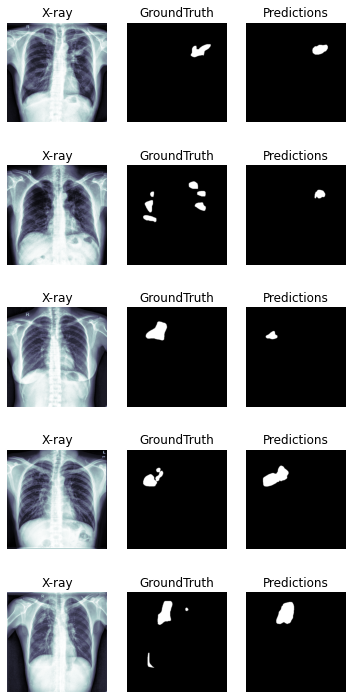

155/155 [==============================] - 76s 492ms/step - loss: -0.6999 - accuracy: 0.9773 - dice_coef: 0.6999 - sensitivity: 0.7103 - specificity: 0.9918 - f1score: 0.7002 - precision: 0.7080 - recall: 0.7103 - mean_iou: 0.5429 - val_loss: -0.4792 - val_accuracy: 0.9775 - val_dice_coef: 0.4792 - val_sensitivity: 0.4126 - val_specificity: 0.9932 - val_f1score: 0.4789 - val_precision: 0.5707 - val_recall: 0.4126 - val_mean_iou: 0.3149
Epoch 32/100
155/155 [==============================] - ETA: 0s - loss: -0.7083 - accuracy: 0.9779 - dice_coef: 0.7083 - sensitivity: 0.7161 - specificity: 0.9920 - f1score: 0.7086 - precision: 0.7134 - recall: 0.7161 - mean_iou: 0.5528
Epoch 00032: val_loss did not improve from -0.52642
155/155 [==============================] - 75s 485ms/step - loss: -0.7083 - accuracy: 0.9779 - dice_coef: 0.7083 - sensitivity: 0.7161 - specificity: 0.9920 - f1score: 0.7086 - precision: 0.7134 - recall: 0.7161 - mean_iou: 0.5528 - val_loss: -0.5210 - val_accuracy: 0.97

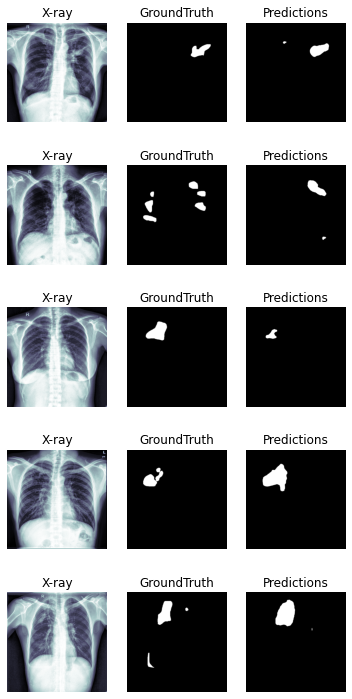

155/155 [==============================] - 77s 495ms/step - loss: -0.7392 - accuracy: 0.9798 - dice_coef: 0.7392 - sensitivity: 0.7462 - specificity: 0.9931 - f1score: 0.7395 - precision: 0.7452 - recall: 0.7462 - mean_iou: 0.5899 - val_loss: -0.5178 - val_accuracy: 0.9756 - val_dice_coef: 0.5178 - val_sensitivity: 0.5292 - val_specificity: 0.9886 - val_f1score: 0.5171 - val_precision: 0.5055 - val_recall: 0.5292 - val_mean_iou: 0.3487
Epoch 42/100
155/155 [==============================] - ETA: 0s - loss: -0.7497 - accuracy: 0.9802 - dice_coef: 0.7497 - sensitivity: 0.7558 - specificity: 0.9931 - f1score: 0.7501 - precision: 0.7528 - recall: 0.7558 - mean_iou: 0.6033
Epoch 00042: val_loss did not improve from -0.53870
155/155 [==============================] - 76s 490ms/step - loss: -0.7497 - accuracy: 0.9802 - dice_coef: 0.7497 - sensitivity: 0.7558 - specificity: 0.9931 - f1score: 0.7501 - precision: 0.7528 - recall: 0.7558 - mean_iou: 0.6033 - val_loss: -0.5266 - val_accuracy: 0.97

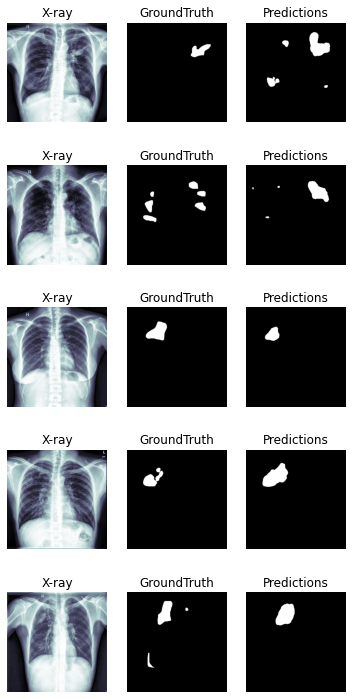

155/155 [==============================] - 76s 488ms/step - loss: -0.7788 - accuracy: 0.9819 - dice_coef: 0.7788 - sensitivity: 0.7762 - specificity: 0.9943 - f1score: 0.7793 - precision: 0.7915 - recall: 0.7762 - mean_iou: 0.6408 - val_loss: -0.4832 - val_accuracy: 0.9684 - val_dice_coef: 0.4832 - val_sensitivity: 0.6114 - val_specificity: 0.9797 - val_f1score: 0.4827 - val_precision: 0.3988 - val_recall: 0.6114 - val_mean_iou: 0.3182
Epoch 52/100
155/155 [==============================] - ETA: 0s - loss: -0.7862 - accuracy: 0.9822 - dice_coef: 0.7862 - sensitivity: 0.7836 - specificity: 0.9944 - f1score: 0.7867 - precision: 0.7950 - recall: 0.7836 - mean_iou: 0.6508
Epoch 00052: val_loss improved from -0.54587 to -0.55638, saving model to ./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-best-model.h5
155/155 [==============================] - 76s 493ms/step - loss: -0.7862 - accuracy: 0.9822 - dice_coef: 0.7862 - sensitivity: 0.7836 - specificity: 0.9944 -

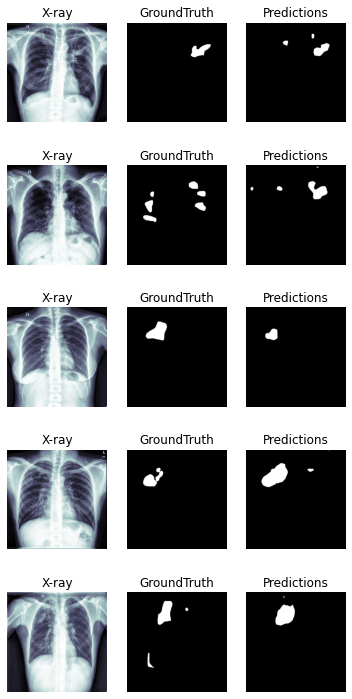

155/155 [==============================] - 76s 488ms/step - loss: -0.8112 - accuracy: 0.9837 - dice_coef: 0.8112 - sensitivity: 0.8056 - specificity: 0.9952 - f1score: 0.8118 - precision: 0.8222 - recall: 0.8056 - mean_iou: 0.6852 - val_loss: -0.5084 - val_accuracy: 0.9733 - val_dice_coef: 0.5084 - val_sensitivity: 0.5623 - val_specificity: 0.9856 - val_f1score: 0.5077 - val_precision: 0.4627 - val_recall: 0.5623 - val_mean_iou: 0.3402
Epoch 62/100
155/155 [==============================] - ETA: 0s - loss: -0.8057 - accuracy: 0.9834 - dice_coef: 0.8057 - sensitivity: 0.8032 - specificity: 0.9950 - f1score: 0.8063 - precision: 0.8163 - recall: 0.8032 - mean_iou: 0.6777
Epoch 00062: val_loss did not improve from -0.55638
155/155 [==============================] - 74s 479ms/step - loss: -0.8057 - accuracy: 0.9834 - dice_coef: 0.8057 - sensitivity: 0.8032 - specificity: 0.9950 - f1score: 0.8063 - precision: 0.8163 - recall: 0.8032 - mean_iou: 0.6777 - val_loss: -0.5346 - val_accuracy: 0.97

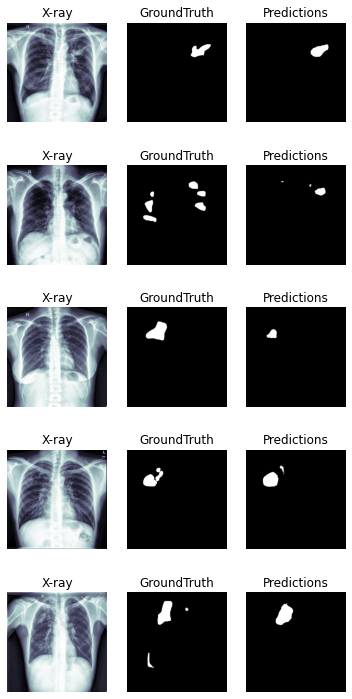

155/155 [==============================] - 72s 464ms/step - loss: -0.8387 - accuracy: 0.9851 - dice_coef: 0.8387 - sensitivity: 0.8314 - specificity: 0.9960 - f1score: 0.8394 - precision: 0.8506 - recall: 0.8314 - mean_iou: 0.7251 - val_loss: -0.5539 - val_accuracy: 0.9799 - val_dice_coef: 0.5539 - val_sensitivity: 0.4912 - val_specificity: 0.9938 - val_f1score: 0.5539 - val_precision: 0.6349 - val_recall: 0.4912 - val_mean_iou: 0.3830
Epoch 72/100
155/155 [==============================] - ETA: 0s - loss: -0.8381 - accuracy: 0.9851 - dice_coef: 0.8381 - sensitivity: 0.8332 - specificity: 0.9959 - f1score: 0.8388 - precision: 0.8478 - recall: 0.8332 - mean_iou: 0.7243
Epoch 00072: val_loss did not improve from -0.55638
155/155 [==============================] - 72s 462ms/step - loss: -0.8381 - accuracy: 0.9851 - dice_coef: 0.8381 - sensitivity: 0.8332 - specificity: 0.9959 - f1score: 0.8388 - precision: 0.8478 - recall: 0.8332 - mean_iou: 0.7243 - val_loss: -0.5046 - val_accuracy: 0.97

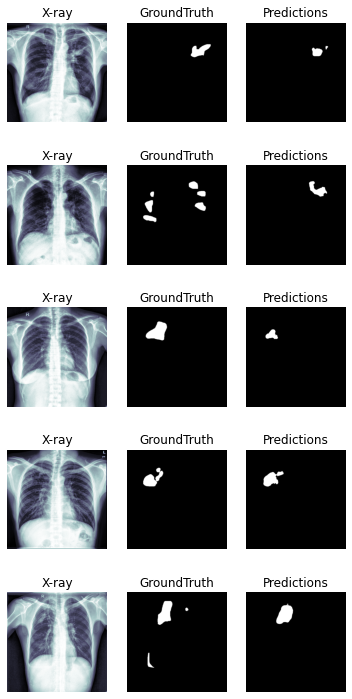

155/155 [==============================] - 77s 498ms/step - loss: -0.8575 - accuracy: 0.9860 - dice_coef: 0.8575 - sensitivity: 0.8490 - specificity: 0.9965 - f1score: 0.8584 - precision: 0.8707 - recall: 0.8490 - mean_iou: 0.7532 - val_loss: -0.5266 - val_accuracy: 0.9800 - val_dice_coef: 0.5266 - val_sensitivity: 0.4366 - val_specificity: 0.9951 - val_f1score: 0.5264 - val_precision: 0.6626 - val_recall: 0.4366 - val_mean_iou: 0.3572
Epoch 82/100
155/155 [==============================] - ETA: 0s - loss: -0.8539 - accuracy: 0.9858 - dice_coef: 0.8539 - sensitivity: 0.8482 - specificity: 0.9963 - f1score: 0.8548 - precision: 0.8648 - recall: 0.8482 - mean_iou: 0.7478
Epoch 00082: val_loss did not improve from -0.55638
155/155 [==============================] - 76s 488ms/step - loss: -0.8539 - accuracy: 0.9858 - dice_coef: 0.8539 - sensitivity: 0.8482 - specificity: 0.9963 - f1score: 0.8548 - precision: 0.8648 - recall: 0.8482 - mean_iou: 0.7478 - val_loss: -0.5143 - val_accuracy: 0.97

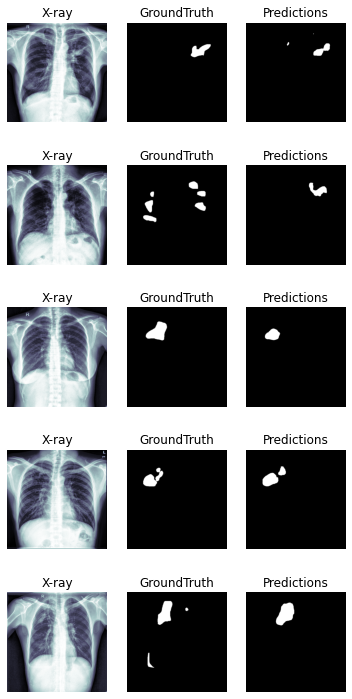

155/155 [==============================] - 77s 499ms/step - loss: -0.8781 - accuracy: 0.9870 - dice_coef: 0.8781 - sensitivity: 0.8680 - specificity: 0.9971 - f1score: 0.8791 - precision: 0.8921 - recall: 0.8680 - mean_iou: 0.7856 - val_loss: -0.5313 - val_accuracy: 0.9793 - val_dice_coef: 0.5313 - val_sensitivity: 0.4648 - val_specificity: 0.9937 - val_f1score: 0.5310 - val_precision: 0.6194 - val_recall: 0.4648 - val_mean_iou: 0.3615
Epoch 92/100
155/155 [==============================] - ETA: 0s - loss: -0.8761 - accuracy: 0.9869 - dice_coef: 0.8761 - sensitivity: 0.8679 - specificity: 0.9970 - f1score: 0.8772 - precision: 0.8884 - recall: 0.8679 - mean_iou: 0.7825
Epoch 00092: val_loss did not improve from -0.55638
155/155 [==============================] - 76s 491ms/step - loss: -0.8761 - accuracy: 0.9869 - dice_coef: 0.8761 - sensitivity: 0.8679 - specificity: 0.9970 - f1score: 0.8772 - precision: 0.8884 - recall: 0.8679 - mean_iou: 0.7825 - val_loss: -0.5146 - val_accuracy: 0.97

In [36]:
# Data Augumentation
data_gen_args = dict(rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     validation_split=0.2)
gen = tf.keras.preprocessing.image.ImageDataGenerator(**data_gen_args)

seed = 2020
batch_size = 10
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = gen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = gen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()

        yield X1i[0], X2i[0]




class prediction_history(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (epoch+1) % 10 == 1:
      print('Prediction Results at epoch: {} are below'.format(epoch+1))
      self.pred = model.predict(images_test)
      plotResults(images_test, masks_test, self.pred)  

def plotResults(images, masks, predictions):
  rows = 5
  cols = 3
  fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(5, 10)) 
  for r in range(rows):
    ax[r][0].imshow(images[r, :, :, 0], cmap='bone')
    ax[r][0].set_title('X-ray', fontsize=12)
    ax[r][0].axis('off')

    ax[r][1].imshow(masks[r, :, :, 0], cmap='gray')
    ax[r][1].set_title('GroundTruth', fontsize=12)
    ax[r][1].axis('off')

    ax[r][2].imshow(predictions[r, :, :, 0], cmap='gray')
    ax[r][2].set_title('Predictions', fontsize=12)
    ax[r][2].axis('off')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.2, hspace=0.2)
  plt.show()
  plt.close() 
  
predictions = prediction_history()

modelDir = './saved Models/FCN8 Models/TB Segmentation from Chest X-rays'
if not os.path.exists(modelDir):
  os.makedirs(modelDir)
  print('Directory Created')
  
csv_logger = tf.keras.callbacks.CSVLogger('./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/Training-Logs.csv')
checkpoint = tf.keras.callbacks.ModelCheckpoint('./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-best-model.h5', verbose=1,
                                                monitor='val_loss', save_best_only=True, mode='auto')  

# Train model
model.fit(XYaugmentGenerator(images_train, masks_train, seed, batch_size), steps_per_epoch=np.ceil(float(len(images_train)) / float(batch_size))*5,
                validation_data = (images_test, masks_test), shuffle=True, epochs=100, callbacks=[csv_logger, checkpoint, predictions])
model.save('./saved Models/FCN8 Models/TB Segmentation from Chest X-rays/tb-segmentation-model.h5')

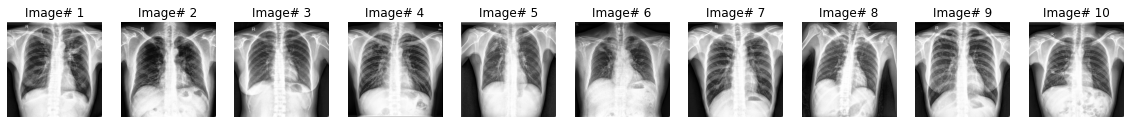

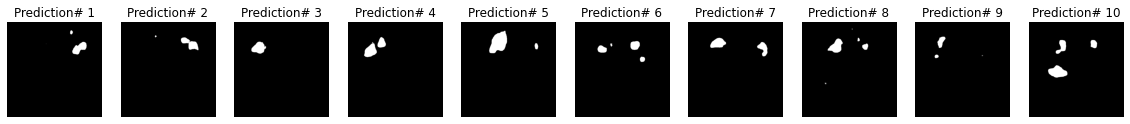

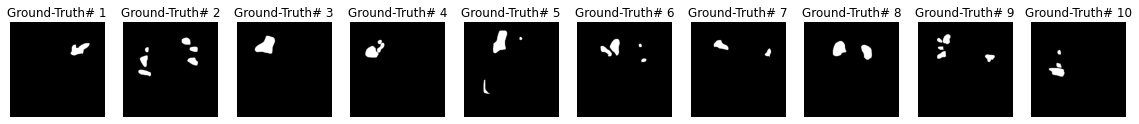

In [48]:
def plotResults(images_test, masks_test, predictions):
  plt.figure(1, figsize = (20, 20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Image# {}' .format(i+1))
    plt.imshow(images_test[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.figure(2, figsize = (20, 20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Prediction# {}' .format(i+1))
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.figure(3, figsize = (20, 20))
  for i in range(10):
    plt.subplot(1, 10, i+1).set_title('Ground-Truth# {}' .format(i+1))
    plt.imshow(masks_test[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.show()
  plt.close()

predictions = model.predict(images_test)
plotResults(images_test, masks_test, predictions)  

